In [1]:
# importando pacotes
import matplotlib
import numpy as np
import pandas as pd 
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# configurando para não omitir linhas no output do dataframe 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Terceira Questão

### Objetivo 

Este projeto tem por objetivo predizer as falhas com um dia de antecedência. Para isso, contamos com a ajuda de dispositivos que retornam diariamente 9 tipos de atributos e temos uma base histórica com as marcações de quando houveram falhas. 

### Entendimento dos dados e exploratória 

Os dados encontram-se em csv (full_devices.csv) 

In [2]:
# puxando os dados
df_full_devices = pd.read_csv("arquivos/full_devices.csv", sep=",", encoding='ISO-8859-1')

print("Dimensão da base:", df_full_devices.shape)
df_full_devices.head(3)

Dimensão da base: (124494, 12)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0


Algumas contagens referentes a base:

In [3]:
print('Data mínima que aparece no histórico:',df_full_devices.date.min())
print('Data máxima que aparece no histórico:',df_full_devices.date.max())
print('Quantidade de devices na base:', df_full_devices.device.nunique())
print('Quantidade de devices marcados com falha:', df_full_devices.failure.sum())

Data mínima que aparece no histórico: 2015-01-01
Data máxima que aparece no histórico: 2015-11-02
Quantidade de devices na base: 1169
Quantidade de devices marcados com falha: 106


___

Vamos analisar como os dados estão por device (2 exemplos):

In [4]:
df_full_devices[df_full_devices.device == 'S1F01085'].head(10)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,0,7


In [5]:
df_full_devices[df_full_devices.device == 'S1F01E6Y'].head(10)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
1165,2015-01-02,S1F01E6Y,0,192723440,0,0,0,12,238718,0,0,0
2328,2015-01-03,S1F01E6Y,0,214317232,0,0,0,12,240021,0,0,0
3491,2015-01-04,S1F01E6Y,0,236917296,0,0,0,12,241264,0,0,0
4653,2015-01-05,S1F01E6Y,0,17099072,0,0,0,12,242553,0,0,0
5814,2015-01-06,S1F01E6Y,0,37263504,0,0,0,12,243875,0,0,0
6866,2015-01-07,S1F01E6Y,0,62055216,0,0,0,12,245207,0,0,0
7664,2015-01-08,S1F01E6Y,0,82886232,0,0,0,12,246493,0,0,0
8420,2015-01-09,S1F01E6Y,0,109504512,0,0,0,12,247666,0,0,0
9176,2015-01-10,S1F01E6Y,0,130876064,0,0,0,12,248950,0,0,0


Os tamanhos dos históricos são diferentes entre os devices, ou seja, alguns possuem histórico maior que os outros.

In [6]:
df_historico = df_full_devices[['date', 'device']] 

# quantidade de historico por device 
df_historico_devices = df_historico.groupby('device').count()
#df_historico_devices.head()

Quantidade de devices com 6 dias:  209


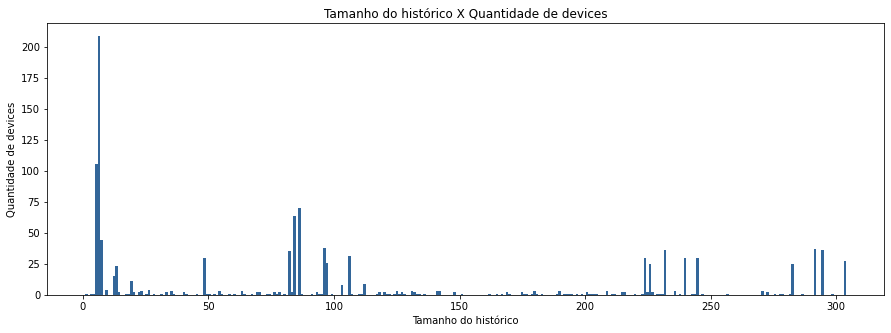

In [7]:
plt.figure(figsize=(15,5))

print('Quantidade de devices com 6 dias: ', df_historico_devices[df_historico_devices.date == 6].shape[0])

plt.hist(
    df_historico_devices
    ,bins = df_full_devices.date.nunique()
    ,color = '#336699'
)

plt.xlabel('Tamanho do histórico')
plt.ylabel('Quantidade de devices')

plt.title('Tamanho do histórico X Quantidade de devices')

plt.show()

In [8]:
print('Data mínima que aparece no histórico:',df_full_devices.date.min())
print('Data máxima que aparece no histórico:',df_full_devices.date.max())

Data mínima que aparece no histórico: 2015-01-01
Data máxima que aparece no histórico: 2015-11-02


Podemos notar pelo gráfico acima que poucos devices estão com histórico (11 meses) inteiro preenchido.

___

Alguns exemplos com falhas para melhor compreensão da base:

In [9]:
# alguns devices que obtiveram falha
df_full_devices[df_full_devices.failure == 1].head(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3
8823,2015-01-09,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,8,0
11957,2015-01-13,W1F13SRV,1,188251248,2040,0,0,6,39345,32,32,1
12668,2015-01-14,W1F1230J,1,220461296,0,0,0,14,325125,0,0,0


In [10]:
df_full_devices[df_full_devices.device == 'S1F0RRB1']

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
235,2015-01-01,S1F0RRB1,0,5230888,2288,0,37,8,39267,24,24,1
1398,2015-01-02,S1F0RRB1,0,13307628,64776,0,49,8,39267,56,56,1
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,56,1
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,56,1
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1


In [11]:
df_full_devices[df_full_devices.device == 'S1F0CTDN']

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3
1226,2015-01-02,S1F0CTDN,0,72104024,528,0,4,9,382459,32,32,3
2389,2015-01-03,S1F0CTDN,0,91492168,528,0,4,9,383713,32,32,3
3552,2015-01-04,S1F0CTDN,0,112311608,528,0,4,9,384948,32,32,3
4713,2015-01-05,S1F0CTDN,0,134261688,528,0,4,9,386214,32,32,3
5856,2015-01-06,S1F0CTDN,0,159974064,528,0,4,9,387343,32,32,3
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3


In [12]:
df_full_devices[df_full_devices.device == 'W1F0PNA5']

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
648,2015-01-01,W1F0PNA5,0,185403491,64776,0,26,30,224801,8,8,0
1811,2015-01-02,W1F0PNA5,0,211326211,64776,0,90,30,224801,8,8,0
2974,2015-01-03,W1F0PNA5,0,234878700,64776,0,91,30,224801,8,8,0
4137,2015-01-04,W1F0PNA5,0,14442703,64776,0,186,30,224801,8,8,0
5298,2015-01-05,W1F0PNA5,0,38285364,64784,0,399,30,224801,8,8,0
6404,2015-01-06,W1F0PNA5,0,65311277,64784,0,400,30,224801,8,8,0
7303,2015-01-07,W1F0PNA5,0,88355682,64784,0,405,30,224801,8,8,0
8067,2015-01-08,W1F0PNA5,0,111562891,64784,0,406,30,224801,8,8,0
8823,2015-01-09,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,8,0


Analisando os exemplos acima, podemos notar que a base ainda não foi trabalhada para modelagem, sendo necessário alguns tratamentos para gerar o dataframe final que irá conter uma linha por device. Geralmente esta etapa é realizada em SQL por questão de performance, contudo, como a base foi disponibilizada em csv para o desafio, vamos realizar os tratamentos no próprio Python.

___

Tratamento da base:

In [13]:
df_contagem = df_full_devices[['device','date']].groupby('device').count()
df_contagem.reset_index(inplace=True)
print('Tamanho da base com quantidade de observações por device:', df_contagem.shape)
df_contagem[df_contagem.device == 'W1F0PNA5'] # exemplo com device que sabemos que deu falha

Tamanho da base com quantidade de observações por device: (1169, 2)


,device,date
653,W1F0PNA5,9


In [14]:
df_median = df_full_devices[['device','attribute1','attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute8','attribute9']].groupby('device').median()
df_median.reset_index(inplace=True)
print('Tamanho da base com medianas:', df_median.shape)
df_median[df_median.device == 'W1F0PNA5'] 

Tamanho da base com medianas: (1169, 10)


,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
653,W1F0PNA5,111562891.0,64784.0,0.0,399.0,30.0,224801.0,8.0,8.0,0.0


In [15]:
df_mean = df_full_devices[['device','attribute1','attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute8','attribute9']].groupby('device').mean()
df_mean.reset_index(inplace=True)
print('Tamanho da base com médias:', df_mean.shape)
df_mean[df_mean.device == 'W1F0PNA5'] 

Tamanho da base com médias: (1169, 10)


,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
653,W1F0PNA5,1.206662e+08,64780.444444,0.0,267.666667,30.0,224801.0,8.0,8.0,0.0


In [16]:
df_resposta = df_full_devices[['device','failure']].groupby('device').sum('failure')
df_resposta.reset_index(inplace=True)
print('Tamanho da base com respostas:', df_resposta.shape)
df_resposta[df_resposta.device == 'W1F0PNA5']  

Tamanho da base com respostas: (1169, 2)


,device,failure
653,W1F0PNA5,1


In [17]:
# vamos unir todas as tabelas acima 
df_modelagem = pd.merge(df_contagem, df_median, on = 'device', how = 'left')
df_modelagem = pd.merge(df_modelagem, df_mean, on = 'device', how = 'left')
df_modelagem = pd.merge(df_modelagem, df_resposta, on = 'device', how = 'left')
df_modelagem[df_modelagem.device == 'W1F0PNA5']  

,device,date,attribute1_x,attribute2_x,attribute3_x,attribute4_x,attribute5_x,attribute6_x,attribute7_x,attribute8_x,attribute9_x,attribute1_y,attribute2_y,attribute3_y,attribute4_y,attribute5_y,attribute6_y,attribute7_y,attribute8_y,attribute9_y,failure
653,W1F0PNA5,9,111562891.0,64784.0,0.0,399.0,30.0,224801.0,8.0,8.0,0.0,1.206662e+08,64780.444444,0.0,267.666667,30.0,224801.0,8.0,8.0,0.0,1


In [18]:
# se o modelo estiver produtivo, o array de device deve ser guardado antes do predict para que seja possível unir com a resposta depois 
df_modelagem = df_modelagem.iloc[:,df_modelagem.columns != 'device']

In [19]:
print('Dimensão da tabela final para modelagem:', df_modelagem.shape)

Dimensão da tabela final para modelagem: (1169, 20)


### Modelagem 

Vamos treinar o modelo:

In [20]:
X = df_modelagem.iloc[:,df_modelagem.columns != 'failure']
y = df_modelagem.iloc[:,df_modelagem.columns == 'failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [21]:
clf = RandomForestClassifier(max_depth=4, random_state=123)
clf.fit(X_train, y_train)

C:\Users\sayur\AppData\Local\Temp/ipykernel_25432/1883066821.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, random_state=123)

Testando o modelo:

In [22]:
resultado = clf.predict(X_test)

In [23]:
print(classification_report(y_test, resultado))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       216
           1       0.80      0.44      0.57        18

    accuracy                           0.95       234
   macro avg       0.88      0.72      0.77       234
weighted avg       0.94      0.95      0.94       234



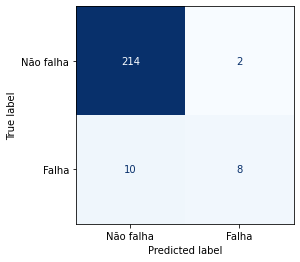

In [24]:
confusion_matrix = metrics.confusion_matrix(y_test, resultado)

display = metrics.ConfusionMatrixDisplay(
    confusion_matrix
    ,display_labels = ["Não falha", "Falha"]
)

display.plot(
    colorbar=False
    ,cmap='Blues'
)

plt.show()

Fim